# Indexing and Selecting Data

## Learning Objectives

- Understanding the difference between position and label-based indexing
- Select data by position using `.isel` with values or slices
- Select data by label using `.sel` with values or slices
- Use nearest-neighbor lookups with `.sel`
- Select timeseries data by date/time with values or slices


## Introduction

Xarray offers extremely flexible indexing routines that combine the best features of NumPy and Pandas for data selection.

The most basic way to access elements of a `DataArray` object is to use Python’s `[]` syntax, such as `array[i, j]`, where `i` and `j` are both integers.

As xarray objects can store coordinates corresponding to each dimension of an array, label-based indexing is also possible (e.g. `.sel(latitude=0)`, similar to `pandas.DataFrame.loc`). In label-based indexing, the element position `i` is automatically looked-up from the coordinate values.

By leveraging the labeled dimensions and coordinates provided by Xarray, users can effortlessly access, subset, and manipulate data along multiple axes, enabling complex operations such as slicing, masking, and aggregating data based on specific criteria. 

This indexing and selection capability of Xarray not only enhances data exploration and analysis workflows but also promotes reproducibility and efficiency by providing a convenient interface for working with multi-dimensional data structures.

## Quick Overview 

In total, xarray supports four different kinds of indexing, as described below and summarized in this table:

| Dimension lookup | Index lookup | `DataArray` syntax   |   `Dataset` syntax   |
| ---------------- | ------------ | ---------------------| ---------------------|
| Positional       | By integer   | `da[:,0]`            | *not available*      |
| Positional       | By label     | `da.loc[:,'IA']`     | *not available*      |
| By name          | By integer   | `da.isel(space=0)` or `da[dict(space=0)]`  | `ds.isel(space=0)` or  `ds[dict(space=0)]`  |
| By name          | By label     | `da.sel(space='IA')` or `da.loc[dict(space='IA')]` | `ds.sel(space='IA')` or `ds.loc[dict(space='IA')]` |


----------

In this tutorial, first we cover the positional indexing and label-based indexing, next we will cover more advanced techniques such as nearest neighbor lookups. 

First, let's import packages: 

In [3]:
import xarray as xr

xr.set_options(display_expand_attrs=False, display_expand_data=False);

Here we’ll use air temperature tutorial dataset from the [National Center for Environmental Prediction](https://www.weather.gov/ncep/). 

In [4]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes: (5)

In [5]:
da = ds["air"]

## Position-based Indexing

Indexing a `DataArray` directly works (mostly) just like it does for numpy `ndarrays`, except that the returned object is always another `DataArray`:



### NumPy Positional Indexing

When working with numpy, indexing is done by position (slices/ranges/scalars).

For example:

In [6]:
np_array = ds["air"].data  # numpy array
np_array.shape

(2920, 25, 53)

Indexing is 0-based in NumPy:

In [7]:
np_array[1, 0, 0]

242.09999

Similarly, we can select a range in NumPy:

In [8]:
# extract a time-series for one spatial location
np_array[:, 20, 40]

array([295.  , 294.4 , 294.5 , ..., 297.29, 297.79, 297.99], dtype=float32)

### Positional Indexing with Xarray

Xarray offers extremely flexible indexing routines that combine the best
features of NumPy and pandas for data selection.

#### NumPy style indexing with Xarray

NumPy style indexing works exactly the same with Xarray but it also preserves labels and metadata. 

This approach however does not take advantage of the dimension names and coordinate location information that is present in a Xarray object.

In [9]:
da[:, 20, 40]

<xarray.DataArray 'air' (time: 2920)>
295.0 294.4 294.5 295.4 295.2 294.4 ... 297.2 297.7 297.3 297.3 297.8 298.0
Coordinates:
    lat      float32 25.0
    lon      float32 300.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

#### Positional Indexing Using Dimension Names

Remembering the axis order can be challenging even with 2D arrays:
- is `np_array[0,3]` the first row and third column or first column and third row? 
- or did I store these samples by row or by column when I saved the data?!. 

The difficulty is compounded with added dimensions. 

Xarray objects eliminate much of the mental overhead by allowing indexing using dimension names instead of axes numbers:

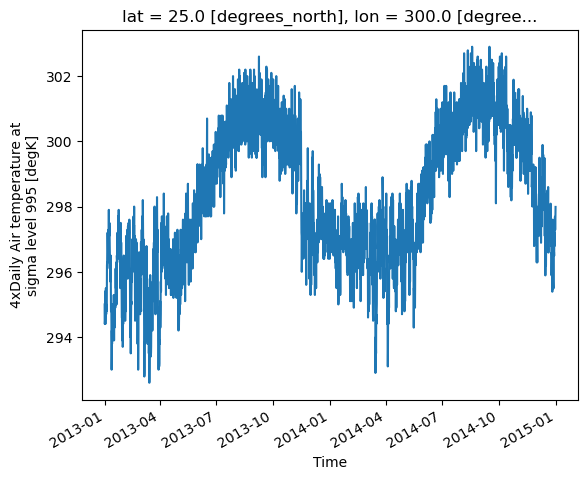

In [10]:
da.isel(lat=20, lon=40).plot();

Slicing is also possible similarly:

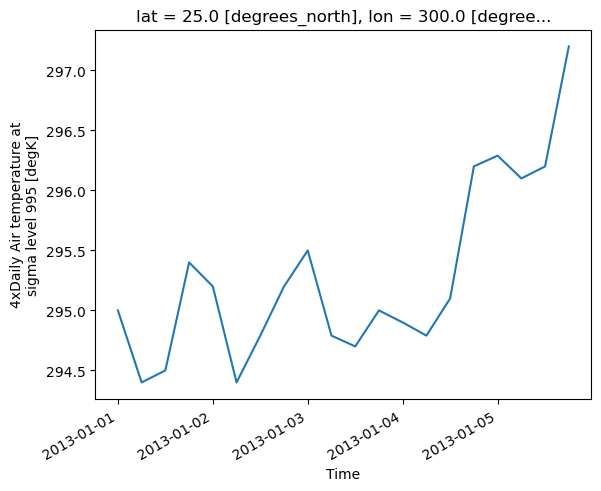

In [11]:
da.isel(time=slice(0, 20), lat=20, lon=40).plot();

```{note}
Using the `isel` method, the user can choose/slice the specific elements from a Dataset or DataArray.
```

Indexing a DataArray directly works (mostly) just like it does for numpy arrays, except that the returned object is always another DataArray; however,when indexing with multiple arrays, positional indexing in Xarray behaves differently compared to NumPy.

```{caution}
Positional indexing deviates from the NumPy behavior when indexing with multiple arrays. 
```
We can show this with an example: 

In [67]:
np_array[:, [0, 1], [0, 1]].shape

(2920, 2)

In [68]:
da[:, [0, 1], [0, 1]].shape

(2920, 2, 2)

Please note how the dimension of the `DataArray()` object is different from the `numpy.ndarray`.

```{tip}
However, users can still achieve NumPy-like pointwise indexing across multiple labeled dimensions by using Xarray vectorized indexing techniques. We will delve further into this topic in the advanced indexing notebook.
```

So far, we have explored positional indexing, which relies on knowing the exact indices. But, what if you wanted to select data specifically for a particular latitude? It becomes challenging to determine the corresponding indices in such cases. Xarray reduce this complexity by introducing label-based indexing. 

## Label-based Indexing

To select data by coordinate labels instead of integer indices we can use the same syntax, using `sel` instead of `isel`:

For example, let's select all data for Lat 25 °N and Lon 210 °E using `sel` :

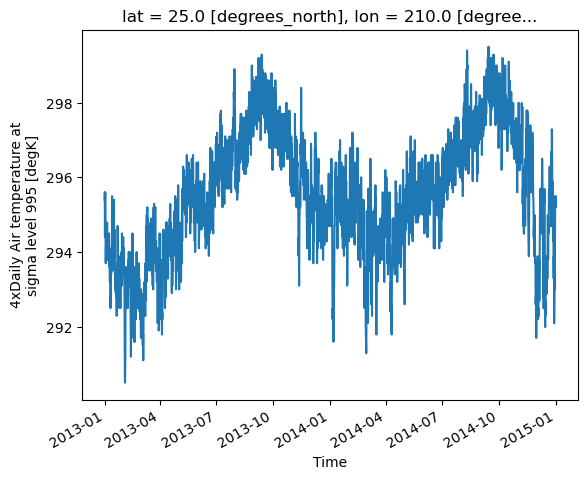

In [19]:
da.sel(lat=25, lon=210).plot();

Similarly we can do slicing or filter a range using the `.slice` function: 

In [25]:
# demonstrate slicing
da.sel(lon=slice(210,215))

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 3)>
244.1 243.9 243.6 243.4 242.4 241.7 ... 298.2 298.1 297.8 298.9 298.7 298.4
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 210.0 212.5 215.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

In [29]:
# demonstrate slicing
da.sel(lat=slice(50,25), lon=slice(210,215))

<xarray.DataArray 'air' (time: 2920, lat: 11, lon: 3)>
279.5 280.1 280.6 279.4 280.3 281.3 ... 295.0 294.6 294.2 295.5 295.6 295.1
Coordinates:
  * lat      (lat) float32 50.0 47.5 45.0 42.5 40.0 ... 35.0 32.5 30.0 27.5 25.0
  * lon      (lon) float32 210.0 212.5 215.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

### Dropping using `drop_sel`

If instead of selecting data we want to drop it, we can use `drop_sel` method with syntax similar to `sel`:

In [30]:
da.drop_sel(lat=50.0, lon=200.0)

<xarray.DataArray 'air' (time: 2920, lat: 24, lon: 52)>
242.5 243.5 244.0 244.1 243.9 243.6 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 202.5 205.0 207.5 210.0 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

So far, all the above will require us to specify exact coordinate values, but what if we don't have the exact values? We can use nearest neighbor lookups to address this issue:

## Nearest Neighbor Lookups

The label based selection methods `sel()` support `method` and `tolerance` keyword argument. The `method` parameter allows for enabling nearest neighbor (inexact) lookups by use of the methods `pad`, `backfill` or `nearest`:

In [55]:
da.sel(lat=52.25, lon=251.8998, method="nearest")

<xarray.DataArray 'air' (time: 2920)>
262.7 263.2 270.9 274.1 273.3 270.6 ... 247.3 253.4 261.6 264.2 265.2 267.0
Coordinates:
    lat      float32 52.5
    lon      float32 252.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

`tolerance` argument limits the maximum distance for valid matches with an inexact lookup:

In [57]:
da.sel(lat=52.25, lon=251.8998, method="nearest", tolerance=2)

<xarray.DataArray 'air' (time: 2920)>
262.7 263.2 270.9 274.1 273.3 270.6 ... 247.3 253.4 261.6 264.2 265.2 267.0
Coordinates:
    lat      float32 52.5
    lon      float32 252.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

```{tip}
All of these indexing methods work on the dataset too!
```

We can also use these methods to index all variables in a dataset simultaneously, returning a new dataset:

In [58]:
ds.sel(lat=52.25, lon=251.8998, method="nearest")

<xarray.Dataset>
Dimensions:  (time: 2920)
Coordinates:
    lat      float32 52.5
    lon      float32 252.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time) float32 262.7 263.2 270.9 274.1 ... 261.6 264.2 265.2 267.0
Attributes: (5)

## Datetime Indexing


Datetime indexing is a critical feature when working with time series data, which is a common occurrence in many fields, including finance, economics, and environmental sciences. Essentially, datetime indexing allows you to select data points or a series of data points that correspond to certain date or time criteria. This becomes essential for time-series analysis where the date or time information associated with each data point can be as critical as the data point itself.

Let's see some of the techniques to perform datetime indexing in Xarray:

### Selecting data based on single datetime

Let's say we have a Dataset ds and we want to select data at a particular date and time, for instance, '2013-01-01' at 6AM. We can do this by using the `sel` (select) method, like so:


In [59]:
ds.sel(time='2013-01-01 06:00')

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01T06:00:00
Data variables:
    air      (lat, lon) float32 242.1 242.7 243.1 243.4 ... 296.4 296.4 296.6
Attributes: (5)

By default, datetime selection will return a range of values that match the provided string. For e.g. `time="2013-01-01"` will return all timestamps for that day (4 of them here):

In [60]:
ds.sel(time='2013-01-01')

<xarray.Dataset>
Dimensions:  (lat: 25, time: 4, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-01-01T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 297.8 298.0 297.9
Attributes: (5)

We can use this feature to select all points in a year:

In [61]:
ds.sel(time="2014")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 1460, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 252.3 251.2 250.0 ... 296.5 296.2 295.7
Attributes: (5)

or a month:

In [62]:
ds.sel(time="2014-May")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 124, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2014-05-01 ... 2014-05-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 264.9 265.0 265.0 ... 296.5 296.2 296.2
Attributes: (5)

### Selecting data for a range of dates

Now, let's say we want to select data between a certain range of dates. We can still use the `sel` method, but this time we will combine it with slice:

In [63]:
# This will return a subset of the dataset corresponding to the entire year of 2013.
ds.sel(time=slice('2013-01-01', '2013-12-31'))

<xarray.Dataset>
Dimensions:  (lat: 25, time: 1460, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.1 295.1 294.7
Attributes: (5)

```{note}

The slice function takes two arguments, start and stop, to make a slice that includes these endpoints. When we use `slice` with the `sel` method, it provides an efficient way to select a range of dates. The above example shows the usage of slice for datetime indexing.

```

### Indexing with a DatetimeIndex or date string list

Another technique is to use a list of datetime objects or date strings for indexing. For example, you could select data for specific, non-contiguous dates like this:

In [64]:
dates = ['2013-07-09', '2013-10-11', '2013-12-24']
ds.sel(time=dates)

<xarray.Dataset>
Dimensions:  (lat: 25, time: 3, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-07-09 2013-10-11 2013-12-24
Data variables:
    air      (time, lat, lon) float32 279.0 278.6 278.1 ... 296.8 296.6 296.5
Attributes: (5)

### Fancy indexing based on year, month, day, or other datetime components

In addition to the basic datetime indexing techniques, Xarray also supports "fancy" indexing options, which can provide more flexibility and efficiency in your data analysis tasks. You can directly access datetime components such as year, month, day, hour, etc. using the `.dt` accessor. Here is an example of selecting all data points from July across all years:

In [65]:
ds.sel(time=ds.time.dt.month == 7)

<xarray.Dataset>
Dimensions:  (lat: 25, time: 248, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-07-01 ... 2014-07-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 273.7 273.0 272.5 ... 297.5 297.6 297.8
Attributes: (5)

Or, if you wanted to select data from a specific day of each month, you could use:

In [66]:
ds.sel(time=ds.time.dt.day == 15)

<xarray.Dataset>
Dimensions:  (lat: 25, time: 96, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-15 ... 2014-12-15T18:00:00
Data variables:
    air      (time, lat, lon) float32 243.8 243.4 242.8 ... 297.1 296.9 296.9
Attributes: (5)

## Exercises

Practice the syntax you’ve learned so far:

```{exercise}
:label: indexing-1

Select the first 30 entries of `latitude` and 30th to 40th entries of `longitude`:
```

````{solution} indexing-1
:class: dropdown
```python
ds.isel(lat=slice(None, 30), lon=slice(30, 40))
```

````

```{exercise}
:label: indexing-2

Select all data at 75 degree north and between Jan 1, 2013 and Oct 15, 2013 :
```
````{solution} indexing-2
:class: dropdown
```python
ds.sel(lat=75, time=slice("2013-01-01", "2013-10-15"))
```
````

```{exercise}
:label: indexing-3

Remove all entries at 260 and 270 degrees :

```
````{solution} indexing-3
:class: dropdown
```python
ds.drop_sel(lon=[260, 270])
```
````

## Summary

In total, Xarray supports four different kinds of indexing, as described below and summarized in this table:


| Dimension lookup | Index lookup | `DataArray` syntax   |   `Dataset` syntax   |
| ---------------- | ------------ | ---------------------| ---------------------|
| Positional       | By integer   | `da[:,0]`            | *not available*      |
| Positional       | By label     | `da.loc[:,'IA']`     | *not available*      |
| By name          | By integer   | `da.isel(space=0)` or `da[dict(space=0)]`  | `ds.isel(space=0)` or  `ds[dict(space=0)]`  |
| By name          | By label     | `da.sel(space='IA')` or `da.loc[dict(space='IA')]` | `ds.sel(space='IA')` or `ds.loc[dict(space='IA')]` |


For enhanced indexing capabilities across all methods, you can utilize DataArray objects as an indexer. For more detailed information, please see the Advanced Indexing notebook.


## More Resources

- [Xarray Docs - Indexing and Selecting Data](https://docs.xarray.dev/en/stable/indexing.html)